In [54]:

# Sentence --->Cleaning--> Normalization --> Tokenizer ---> Vocab2number ---> Padding ---> Numerical input --->
#               Word2vecModel---> Dimentionality Reduction(sentences, words, features)
#                 ||
#             (setnences, features)

'''
---> FNN(Wx+b) ---> TimeDistribuation(sentences, units)
            ---> (sentences, 1, units)
         ---> LSTM based NN
         ---> HoF Prediction
'''

'\n---> FNN(Wx+b) ---> TimeDistribuation(sentences, units)\n            ---> (sentences, 1, units)\n         ---> LSTM based NN\n         ---> HoF Prediction\n'

In [55]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec


In [56]:
df = pd.read_csv('HoF_data.tsv', sep='\t')
X, Y = df.Tweet, df['Task A ']



In [57]:

def text_transformation(text_data):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(text_data)
    transformed_text = tokenizer.texts_to_sequences(text_data)
    padded_text = pad_sequences(transformed_text, padding="pre", value=0)
    return tokenizer, padded_text


In [58]:
def inverse_transformation(tokenizer, test_data):
    tokenizer_dict = dict((v, k) for k,v in tokenizer.word_index.items())
    sentences = []
    for transformed_text in tokenizer.texts_to_sequences(test_data):
        sentence = []
        for token in transformed_text:
            sentence.append(tokenizer_dict[token])
        sentences.append(sentence)
        del sentence
    return sentences


In [59]:
def pretrained_embedding_creation(tokenizer, text_data, vector_size, model_name):
    tokenized_text = inverse_transformation(tokenizer, text_data)
    word2vec_model = Word2Vec(tokenized_text, size=vector_size, window=3, min_count=1)
    word2vec_model.save(model_name)


In [60]:
def label_encoder(Y):
    class_label_encoder = LabelEncoder()
    class_label_encoder.fit(Y)
    y_transformed = class_label_encoder.transform(Y).reshape(-1, 1)
    return class_label_encoder, y_transformed



In [61]:

def map_vector(tokenizer, word2vec_model):
    vocab = tokenizer.word_index
    vocab_size = len(vocab) + 1
    weight_matrix = np.zeros((vocab_size, 50))

    for word, i in vocab.items():
        try:
            weight_matrix[i] = word2vec_model.wv[word]
        except:
            pass
    return weight_matrix


In [62]:
Tokenizer, x_data = text_transformation(X)
label_encoder, y_data = label_encoder(Y)
pretrained_embedding_creation(Tokenizer, X, 50, 'HoF_embedding.model')


In [63]:
X_train, X_test, Y_train, Y_test = train_test_split(x_data, y_data, test_size=0.2, shuffle=True)


# Load pretrained embedding from word2vec model
w2v_model = Word2Vec.load('HoF_embedding.model')
print(w2v_model)

Word2Vec(vocab=15497, size=50, alpha=0.025)


In [64]:

'''
vocab_size = 1 x 10000
output = 1 x 100
1.  Pretrained embeddings (PE)
2.  Input(Embedding Layer) == Output(Pretrained Embedding)
tokenizer.word_index = {'the':1, 'is':2, 'us':3, ......., 'home':10000}
PE = {'is':1, 'home':2, 'us':3, ......, 'the':10010}
'''

# Map numerical representation with pretrained embedding with respect to the token
weight_matrix = map_vector(Tokenizer, w2v_model)


def singleLayerModel(vocab_size, embedding_dim, lstm_units):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, trainable=False))
    model.add(LSTM(units=lstm_units, return_sequences=False))
    model.add(Dense(1, activation='sigmoid'))
    print(model.summary())
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


sDLM = singleLayerModel(len(Tokenizer.word_index)+1, 50, 10)
sDLM_history = sDLM.fit(X_train, Y_train, epochs=10, batch_size=120)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 50)          774900    
                                                                 
 lstm_1 (LSTM)               (None, 10)                2440      
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 777,351
Trainable params: 2,451
Non-trainable params: 774,900
_________________________________________________________________
None
Epoch 1/10
24/24 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.4975
Epoch 2/10
24/24 [==============================] - 0s 17ms/step - loss: 0.6926 - accuracy: 0.5164
Epoch 3/10
24/24 [==============================] - 0s 17ms/step - loss: 0.6921 - accuracy: 0.5167
Epoch 

In [66]:
predictedion = sDLM.predict(X_test)

In [67]:
predict_class = list()
for pred_prob in predictedion:
  if pred_prob >= 0.5:
    predict_class.append(1)
  else:
    predict_class.append(0)

predicted_labels = label_encoder.inverse_transform(predict_class)
Y_test_labels = label_encoder.inverse_transform(Y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [68]:
from sklearn import metrics

score = metrics.classification_report(Y_test_labels, predicted_labels, target_names=label_encoder.classes_)
cf_matrix = metrics.confusion_matrix(Y_test_labels, predicted_labels, labels=label_encoder.classes_)
print(score)
print(cf)


              precision    recall  f1-score   support

         HOF       0.56      0.71      0.63       361
         NOT       0.57      0.40      0.47       343

    accuracy                           0.56       704
   macro avg       0.56      0.56      0.55       704
weighted avg       0.56      0.56      0.55       704

[[266 101]
 [205 132]]


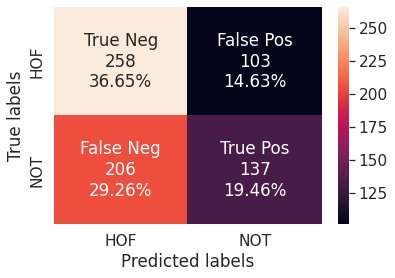

In [69]:
import seaborn as sn
import matplotlib.pyplot as plt


group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sn.set(font_scale=1.4) # for label size
ax= plt.subplot()
sn.heatmap(df_cm, annot=labels, fmt='') # font size
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.xaxis.set_ticklabels(label_encoder.classes_)
ax.yaxis.set_ticklabels(label_encoder.classes_)

plt.show()